# ECON 470 Homework 4-1
##### Ellen Wu

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from tabulate import tabulate
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

In [24]:
#Load dataset
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")
df["year"] = pd.to_datetime(df["contract_date"], errors="coerce").dt.year

1. Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits). Provide a box and whisker plot showing the distribution of plan counts by county over time. Do you think that the number of plans is sufficient, too few, or too many?

In [25]:
# Start with your full DataFrame (e.g., df)
filtered = df.copy()

# Keep only years 2010–2015
filtered = filtered[filtered["year"].between(2010, 2015)]

# Remove SNPs
filtered = filtered[filtered["snp"] != "Yes"]

# Remove 800-series plans
filtered = filtered[~filtered["planid"].astype(str).str.startswith("800")]

# Remove prescription drug-only plans (no Part C) — assuming these are labeled PDP
filtered = filtered[filtered["plan_type"] != "PDP"]

# Optional: sanity check year distribution
print(filtered["year"].value_counts().sort_index())

2010.0    6522
2011.0    2619
2012.0     172
2013.0     665
2014.0    1828
2015.0     722
Name: year, dtype: int64


In [26]:
plan_counts = (
    filtered.groupby(["year", "county"])
    .size()
    .reset_index(name="plan_count")
)

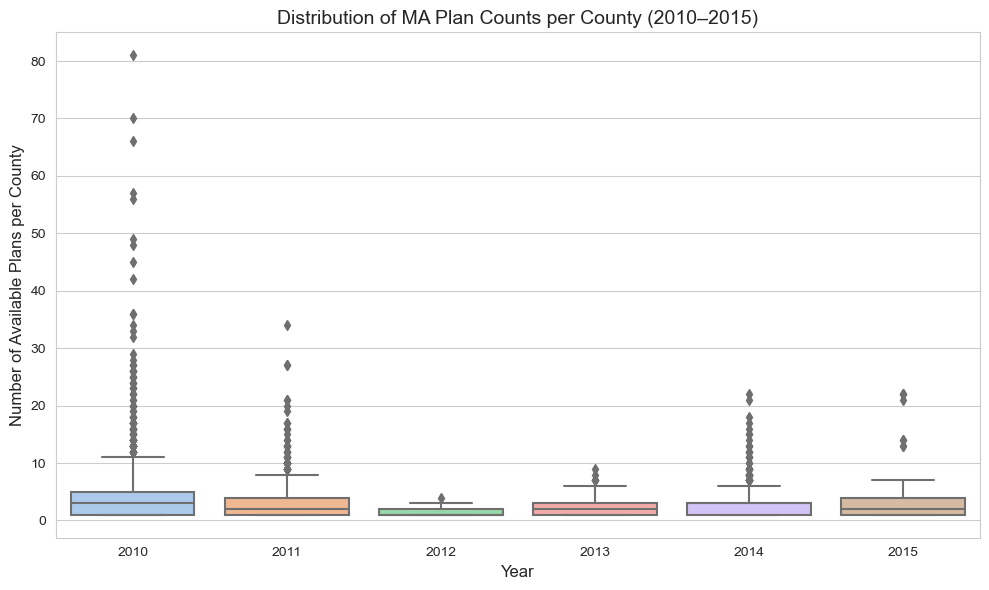

In [30]:
# Make sure year is an integer
plan_counts["year"] = plan_counts["year"].astype(int)

# Sort by year
plan_counts = plan_counts.sort_values(by="year")

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot(x="year", y="plan_count", data=plan_counts, palette="pastel")

# Tidy up
plt.title("Distribution of MA Plan Counts per County (2010–2015)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Available Plans per County", fontsize=12)
plt.xticks(rotation=0)  # Make labels horizontal
plt.tight_layout()
plt.show()

2. Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

In [65]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

df["contract_year"] = pd.to_datetime(df["contract_date"], errors="coerce").dt.year

# Clean Star Ratings
df["Star_Rating"].replace(["", " "], np.nan, inplace=True)
df["Star_Rating"] = pd.to_numeric(df["Star_Rating"], errors="coerce")

# Filter for 2010, 2012, 2015 from original year column
years_to_plot = [2010, 2012, 2015]
ratings_subset = df[df["year"].isin(years_to_plot) & df["Star_Rating"].notna()]

⚠️ No data for year 2010
⚠️ No data for year 2012


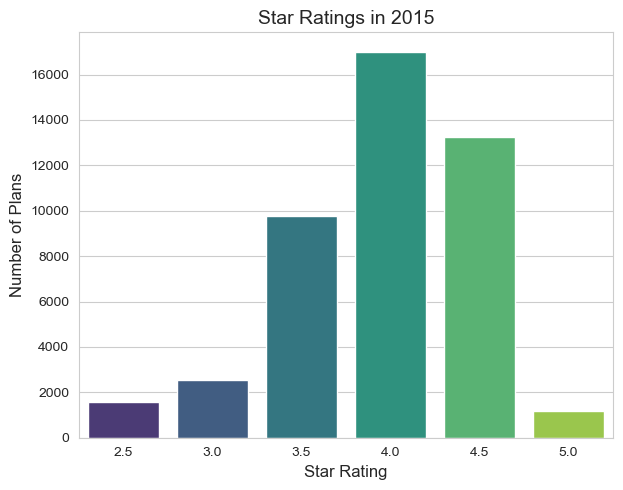

In [66]:
plt.figure(figsize=(18, 5))  # Slightly wider

for i, year in enumerate(years_to_plot):
    data_year = ratings_subset[ratings_subset["year"] == year]

    if data_year.empty:
        print(f"⚠️ No data for year {year}")
        continue

    plt.subplot(1, 3, i + 1)
    sns.countplot(data=data_year, x="Star_Rating", palette="viridis")
    plt.title(f"Star Ratings in {year}", fontsize=14)
    plt.xlabel("Star Rating", fontsize=12)
    plt.ylabel("Number of Plans", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

3. Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

In [20]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

# Filter for years 2010–2015
bench_2010_2015 = df[
    (df["year"].between(2010, 2015)) & 
    (df["ma_rate"].notna())
]

# Group by year and calculate the average benchmark
avg_benchmark = (
    bench_2010_2015.groupby("year")["ma_rate"]
    .mean()
    .reset_index()
)

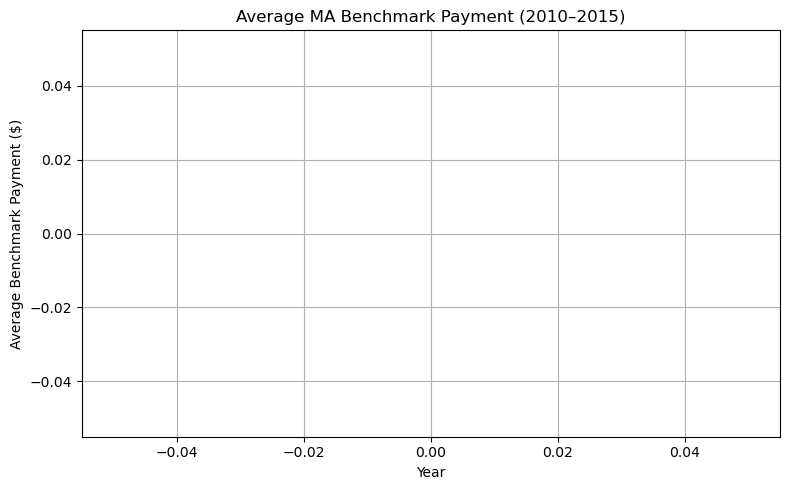

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(avg_benchmark["year"], avg_benchmark["ma_rate"], marker='o', linestyle='-')
plt.title("Average MA Benchmark Payment (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average Benchmark Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
rate_2010 = avg_benchmark[avg_benchmark["year"] == 2010]["ma_rate"].values[0]
rate_2015 = avg_benchmark[avg_benchmark["year"] == 2015]["ma_rate"].values[0]
change = rate_2015 - rate_2010
percent_change = (change / rate_2010) * 100

print(f"Average benchmark payment increased by ${change:.2f}, or {percent_change:.2f}%, from 2010 to 2015.")

IndexError: index 0 is out of bounds for axis 0 with size 0